In [1]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
import os

def make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion=0.7, seed=2437, 
              quadrant_params=None, stationarity_zones=None):
    samples = np.zeros((n_samples, grid_size, grid_size))
    
    for i in range(n_samples):
        seed = seed + i
        local_field = np.zeros((grid_size, grid_size))
        
        if quadrant_params:
            mid_x, mid_y = grid_size // 2, grid_size // 2
            
            for qx in range(2):
                for qy in range(2):
                    lx_start = qx * mid_x
                    lx_end = (qx + 1) * mid_x
                    ly_start = qy * mid_y
                    ly_end = (qy + 1) * mid_y
                    
                    q_len_scale = quadrant_params[qx * 2 + qy]['len_scale']
                    q_smoothness = quadrant_params[qx * 2 + qy]['smoothness']
                    
                    cov_model = gs.Matern(dim=2, var=global_var, len_scale=q_len_scale, nu=q_smoothness)
                    srf = gs.SRF(cov_model)
                    
                    x = np.linspace(0, 1, mid_x)
                    y = np.linspace(0, 1, mid_y)
                    
                    GRF = srf.structured((x, y), seed=seed)
                    local_field[lx_start:lx_end, ly_start:ly_end] = GRF
        else:
            cov_model = gs.Matern(dim=2, var=global_var, len_scale=global_len_scale, nu=smoothness)
            srf = gs.SRF(cov_model)
            x = np.linspace(0, 1, grid_size)
            y = np.linspace(0, 1, grid_size)
            local_field = srf.structured((x, y), seed=seed)
        
        if stationarity_zones:
            for (cx, cy, radius, mean_value) in stationarity_zones:
                for xi in range(grid_size):
                    for yi in range(grid_size):
                        if (xi - cx)**2 + (yi - cy)**2 < radius**2:
                            local_field[xi, yi] += mean_value
        
        # Truncate to binary array at 60th percentile
        threshold = np.percentile(local_field, proportion*100)
        sample = np.zeros_like(local_field)
        sample[local_field > threshold] = 1
        samples[i] = sample
        print(f"Sample number: {i+1}/{n_samples} for current configuration.")
    
    return samples

In [9]:
import numpy as np

# Helper function to generate random positions and scale them
def generate_positions(grid_size, n_objects, seed, base_resolution, resolution, margin=5):
    np.random.seed(seed)
    scale = resolution / base_resolution
    return [(int(np.random.randint(margin, base_resolution - margin) * scale), 
             int(np.random.randint(margin, base_resolution - margin) * scale)) 
            for _ in range(n_objects)]

# Helper functions to create masks for different shapes
def create_square_mask(grid_size, position, size, distortion, seed, scale):
    np.random.seed(seed)
    x, y = np.ogrid[:grid_size[0], :grid_size[1]]
    distorted_size = (size * scale) + np.random.normal(0, distortion)
    half_size = distorted_size / 2
    mask = ((np.abs(x - position[0]) <= half_size) & 
            (np.abs(y - position[1]) <= half_size) & 
            (position[0] - half_size >= 0) & 
            (position[0] + half_size < grid_size[0]) & 
            (position[1] - half_size >= 0) & 
            (position[1] + half_size < grid_size[1]))
    return mask

def create_circle_mask(grid_size, position, radius, distortion, seed, scale):
    np.random.seed(seed)
    x, y = np.ogrid[:grid_size[0], :grid_size[1]]
    dist_from_center = np.sqrt((x - position[0])**2 + (y - position[1])**2)
    distorted_radius = (radius * scale) + np.random.normal(0, distortion)
    mask = (dist_from_center <= distorted_radius) & (position[0] - distorted_radius >= 0) & (position[0] + distorted_radius < grid_size[0]) & (position[1] - distorted_radius >= 0) & (position[1] + distorted_radius < grid_size[1])
    return mask

def create_ellipse_mask(grid_size, position, radii, distortion, seed, scale):
    np.random.seed(seed)
    x, y = np.ogrid[:grid_size[0], :grid_size[1]]
    scaled_radii = radii * scale
    dist_from_center = ((x - position[0]) / scaled_radii[0])**2 + ((y - position[1]) / scaled_radii[1])**2
    distorted_dist = dist_from_center + np.random.normal(0, distortion)
    mask = (distorted_dist <= 1) & (position[0] - scaled_radii[0] >= 0) & (position[0] + scaled_radii[0] < grid_size[0]) & (position[1] - scaled_radii[1] >= 0) & (position[1] + scaled_radii[1] < grid_size[1])
    return mask

# Main function to create the binary image with constrained sizes
def make_realizations(seed, resolution, base_resolution=64):
    np.random.seed(seed)
    
    grid_size = (resolution, resolution)
    scale = resolution / base_resolution
    
    # Random number of each shape
    n_rectangles = np.random.randint(1, 10)
    n_circles = np.random.randint(1, 10)
    n_ellipses = np.random.randint(1, 10)

    # Smaller sizes and distortions for shapes, scaled relative to base resolution
    rectangle_sizes = np.random.randint(2, 10, size=n_rectangles)  # Reduced sizes
    rectangle_distortions = np.random.uniform(0, 2, size=n_rectangles)
    circle_radii = np.random.randint(2, 8, size=n_circles)  # Reduced radii
    circle_distortions = np.random.uniform(0, 2, size=n_circles)
    ellipse_radii = np.random.randint(2, 8, size=(n_ellipses, 2))  # Reduced radii for ellipses
    ellipse_distortions = np.random.uniform(0, 2, size=n_ellipses)

    # Generate scaled positions for shapes, with a margin to prevent objects from being at the grid edges
    rectangle_positions = generate_positions(grid_size[0], n_rectangles, seed, base_resolution, resolution)
    circle_positions = generate_positions(grid_size[0], n_circles, seed, base_resolution, resolution)
    ellipse_positions = generate_positions(grid_size[0], n_ellipses, seed, base_resolution, resolution)

    # Initialize the grid
    objects = np.zeros(grid_size)

    # Add rectangles to the grid
    for i in range(n_rectangles):
        size = rectangle_sizes[i]
        distortion = rectangle_distortions[i]
        position = rectangle_positions[i]
        mask = create_square_mask(grid_size, position, size, distortion, seed, scale)
        objects[mask] = 1

    # Add circles to the grid
    for i in range(n_circles):
        radius = circle_radii[i]
        distortion = circle_distortions[i]
        position = circle_positions[i]
        mask = create_circle_mask(grid_size, position, radius, distortion, seed, scale)
        objects[mask] = 1

    # Add ellipses to the grid
    for i in range(n_ellipses):
        radii = ellipse_radii[i]
        distortion = ellipse_distortions[i]
        position = ellipse_positions[i]
        mask = create_ellipse_mask(grid_size, position, radii, distortion, seed, scale)
        objects[mask] = 1

    return objects

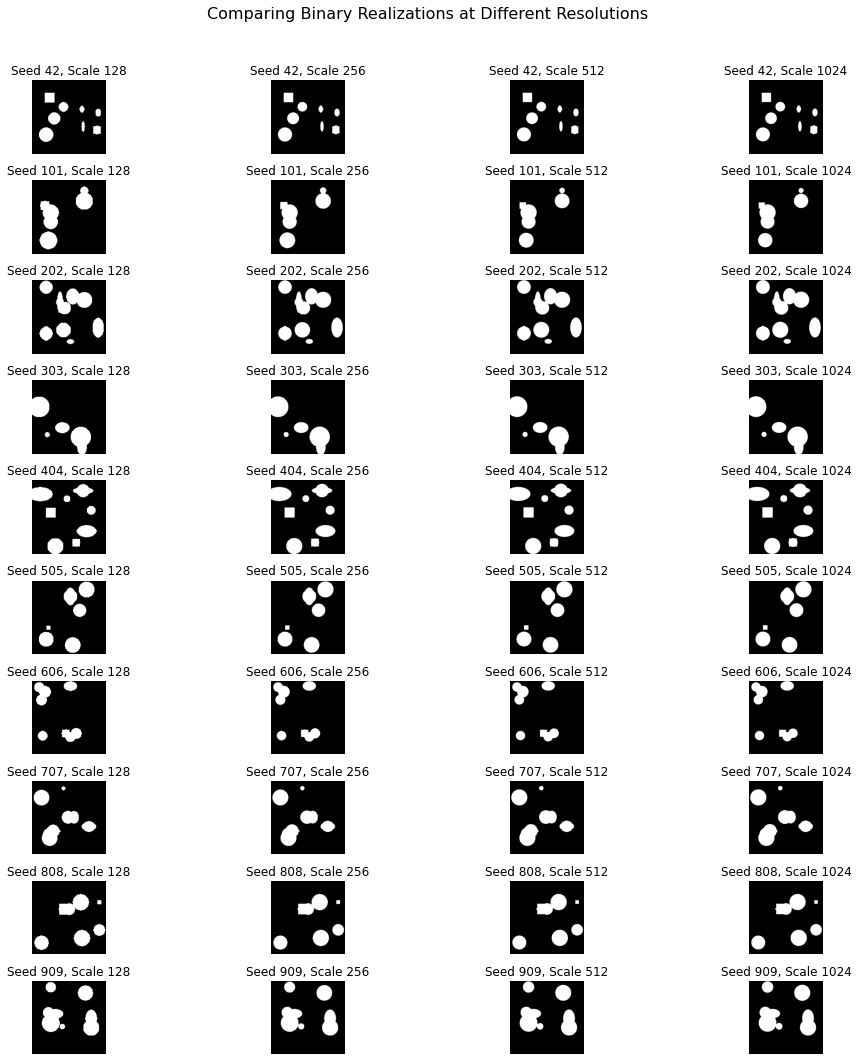

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming make_realizations is already defined as per the modified code

def plot_realizations(seed_list, scales):
    fig, axes = plt.subplots(len(seed_list), len(scales), figsize=(15, 15))
    fig.suptitle('Comparing Binary Realizations at Different Resolutions', fontsize=16)

    for i, seed in enumerate(seed_list):
        for j, scale in enumerate(scales):
            realization = make_realizations(seed, scale)
            ax = axes[i, j]
            ax.imshow(realization, cmap='gray')
            ax.set_title(f'Seed {seed}, Scale {scale}')
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Create 10 seeds for different realizations
seeds = [42, 101, 202, 303, 404, 505, 606, 707, 808, 909]

# Define 4 different scales/resolutions
scales = [128, 256, 512, 1024]

# Call the plotting function
plot_realizations(seeds, scales)

In [12]:
seeds = np.random.randint(0, 10000, size=50)
# Save the seeds to a file
np.savetxt('/Users/oscaro/Library/CloudStorage/OneDrive-NTNU/PhD/Paper_3/Data/seeds_resolution.txt', seeds)
resolutions = [128, 256, 512, 1024]
# Make realizations for each seed and resolution 
small_resolutions = []
medium_resolutions = []
large_resolutions = []
extra_large_resolutions = []
for seed in seeds:
    small_resolutions.append(make_realizations(seed, resolutions[0]))
    medium_resolutions.append(make_realizations(seed, resolutions[1]))
    large_resolutions.append(make_realizations(seed, resolutions[2]))
    extra_large_resolutions.append(make_realizations(seed, resolutions[3]))
# Save the realizations to a file
np.save('/Users/oscaro/Library/CloudStorage/OneDrive-NTNU/PhD/Paper_3/Data/small_resolutions.npy', np.array(small_resolutions))
np.save('/Users/oscaro/Library/CloudStorage/OneDrive-NTNU/PhD/Paper_3/Data/medium_resolutions.npy', np.array(medium_resolutions))
np.save('/Users/oscaro/Library/CloudStorage/OneDrive-NTNU/PhD/Paper_3/Data/large_resolutions.npy', np.array(large_resolutions))
np.save('/Users/oscaro/Library/CloudStorage/OneDrive-NTNU/PhD/Paper_3/Data/extra_large_resolutions.npy', np.array(extra_large_resolutions))
                                   

In [2]:
import numpy as np

def generate_positions(grid_size, n_objects):
    return [(np.random.randint(0, grid_size), np.random.randint(0, grid_size)) for _ in range(n_objects)]

def create_square_mask(grid_size, position, size, distortion):
    x, y = np.ogrid[:grid_size[0], :grid_size[1]]
    distorted_size = size + np.random.normal(0, distortion, grid_size)
    mask = (np.abs(x - position[0]) <= distorted_size/2) & (np.abs(y - position[1]) <= distorted_size/2)
    return mask
def create_circle_mask(grid_size, position, radius, distortion):
    x, y = np.ogrid[:grid_size[0], :grid_size[1]]
    dist_from_center = np.sqrt((x - position[0])**2 + (y - position[1])**2)
    distorted_radius = radius + np.random.normal(0, distortion, dist_from_center.shape)
    mask = dist_from_center <= distorted_radius
    return mask

def create_ellipse_mask(grid_size, position, radii, distortion):
    x, y = np.ogrid[:grid_size[0], :grid_size[1]]
    dist_from_center = ((x - position[0])/radii[0])**2 + ((y - position[1])/radii[1])**2
    distorted_dist = dist_from_center + np.random.normal(0, distortion, dist_from_center.shape)
    mask = distorted_dist <= 1
    return mask

def make_objects(grid_size, n_rectangles, rectangle_sizes, rectangle_distortions, rectangle_positions, 
                 n_circles, circle_radii, circle_distortions, circle_positions, 
                 n_ellipses, ellipse_radii, ellipse_distortions, ellipse_positions, overlap=False):
    
    if rectangle_positions is None:
        rectangle_positions = generate_positions(grid_size, n_rectangles)
    if circle_positions is None:
        circle_positions = generate_positions(grid_size, n_circles)
    if ellipse_positions is None:
        ellipse_positions = generate_positions(grid_size, n_ellipses)

    objects = np.zeros(grid_size)

    for i in range(n_rectangles):
        size = rectangle_sizes[i]
        distortion = rectangle_distortions[i]
        position = rectangle_positions[i]
        mask = create_square_mask(grid_size, position, size, distortion)
        if overlap or not np.any(objects[mask]):
            objects[mask] = 1

    for i in range(n_circles):
        radius = circle_radii[i]
        distortion = circle_distortions[i]
        position = circle_positions[i]
        mask = create_circle_mask(grid_size, position, radius, distortion)
        if overlap or not np.any(objects[mask]):
            objects[mask] = 1

    for i in range(n_ellipses):
        radii = ellipse_radii[i]
        distortion = ellipse_distortions[i]
        position = ellipse_positions[i]
        mask = create_ellipse_mask(grid_size, position, radii, distortion)
        if overlap or not np.any(objects[mask]):
            objects[mask] = 1

    return objects

In [ ]:
def make_realizations(seed,resolution):
    
    nr_of_objects = np.random.randint()
    positions = generate_positions(seed)

In [167]:
grid_size = (400, 400)
n_ellipses_per_row = 10  # Number of ellipses in each row and column
ellipse_radii = [(20, 10)] * n_ellipses_per_row**2  # Same radii for all ellipses

# Determine the offset based on the largest radius of the ellipses
offset = max(max(radii) for radii in ellipse_radii)

# Create a grid of positions with the offset
x_positions = np.repeat(np.arange(n_ellipses_per_row), n_ellipses_per_row) * 50 + offset
y_positions = np.tile(np.arange(n_ellipses_per_row), n_ellipses_per_row) * 50 + offset

# Combine x and y positions to create a checkerboard pattern
ellipse_positions = list(zip(x_positions, y_positions))
structured_ellipses = np.zeros((50,400,400))
for i in range(50):
    structured_ellipses[i,:,:] = make_objects(grid_size, 0, [], [], [], 
                               0, [], [], [],
                               n_ellipses_per_row**2, ellipse_radii, [0]*n_ellipses_per_row**2, ellipse_positions)  # No distortion

In [171]:
np.save('structured_ellipses.npy', structured_ellipses)

In [178]:
grid_size = (400, 400)
n_ellipses = 20
ellipse_radii = [(20, 10)] * n_ellipses  # Same radii for all ellipses
ellipse_distortions = [0.1] * n_ellipses  # Distortion of 0.1 for all ellipses

realizations = []

for _ in range(50):  # Generate 10 realizations
    # Generate random positions for the ellipses
    ellipse_positions = [(np.random.randint(0, grid_size[0]), np.random.randint(0, grid_size[1])) for _ in range(n_ellipses)]
    
    ellipse_objects = make_objects(grid_size, 0, [], [], [], 
                                   0, [], [], [],
                                   n_ellipses, ellipse_radii, ellipse_distortions, ellipse_positions)  # No distortion
    
    realizations.append(ellipse_objects)

# Now `realizations` is a list of 10 numpy arrays, each representing a different realization of the ellipses

In [179]:
ellipse_with_distortion = np.zeros((50,400,400))
for i in range(50):
    ellipse_with_distortion[i,:,:] = realizations[i]
np.save('ellipse_with_distortion.npy', ellipse_with_distortion)

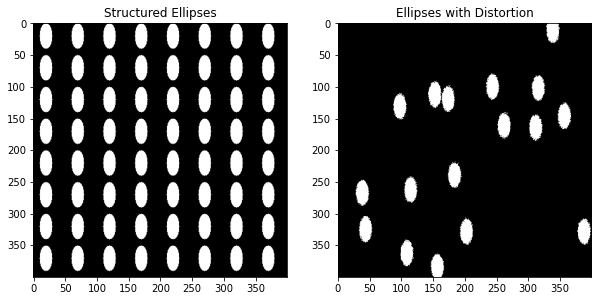

In [180]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(structured_ellipses[0], cmap='gray')
axs[0].set_title('Structured Ellipses')
axs[1].imshow(ellipse_with_distortion[0], cmap='gray')
axs[1].set_title('Ellipses with Distortion')
plt.show()

In [193]:
grid_size = (200, 200)

n_circles = 5
circle_radii = [1/20*grid_size[0]] * n_circles  # 1/20 of the grid size
circle_distortions = [0] * n_circles  # No distortion for circles

n_ellipses = 10
ellipse_radii = [(1/40*grid_size[0], 1/80*grid_size[0])] * n_ellipses  # Half the radius for all ellipses
ellipse_distortions = [0] * n_ellipses  # No distortion for ellipses

realizations = []

for _ in range(50):  # Generate 10 realizations
    # Generate positions for the circles in the upper left corner
    circle_positions = [(np.random.randint(0, grid_size[0]//4), np.random.randint(0, grid_size[1]//4)) for _ in range(n_circles)]

    # Generate positions for the ellipses in the lower right corner
    ellipse_positions = [(np.random.randint(3*grid_size[0]//4, grid_size[0]), np.random.randint(3*grid_size[1]//4, grid_size[1])) for _ in range(n_ellipses)]
    
    objects = make_objects(grid_size, 0, [], [], [], 
                       n_circles, circle_radii, circle_distortions, circle_positions,
                       n_ellipses, ellipse_radii, ellipse_distortions, ellipse_positions,
                       overlap=True)  # Allow overlap
    
    realizations.append(objects)

# Now `realizations` is a list of 10 numpy arrays, each representing a different realization of the circles and ellipses

In [194]:
np.save('circles_and_ellipses_small.npy', realizations)

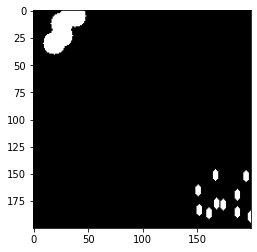

In [195]:
plt.imshow(realizations[0], cmap='gray')
plt.show()

In [196]:
# Do the same for medium grid size
grid_size = (400, 400)

n_circles = 5
circle_radii = [1/20*grid_size[0]] * n_circles  # 1/20 of the grid size
circle_distortions = [0] * n_circles  # No distortion for circles

n_ellipses = 10
ellipse_radii = [(1/40*grid_size[0], 1/80*grid_size[0])] * n_ellipses  # Half the radius for all ellipses
ellipse_distortions = [0] * n_ellipses  # No distortion for ellipses

realizations = []

for _ in range(50):  # Generate 10 realizations
    # Generate positions for the circles in the upper left corner
    circle_positions = [(np.random.randint(0, grid_size[0]//4), np.random.randint(0, grid_size[1]//4)) for _ in range(n_circles)]

    # Generate positions for the ellipses in the lower right corner
    ellipse_positions = [(np.random.randint(3*grid_size[0]//4, grid_size[0]), np.random.randint(3*grid_size[1]//4, grid_size[1])) for _ in range(n_ellipses)]
    
    objects = make_objects(grid_size, 0, [], [], [], 
                       n_circles, circle_radii, circle_distortions, circle_positions,
                       n_ellipses, ellipse_radii, ellipse_distortions, ellipse_positions,
                       overlap=True)  # Allow overlap
    
    realizations.append(objects)

In [197]:
np.save('circles_and_ellipses_medium.npy', realizations)

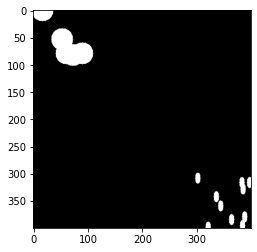

In [198]:
plt.imshow(realizations[0], cmap='gray')
plt.show()

In [199]:
# Do the same for large grid size
grid_size = (800, 800)

n_circles = 5
circle_radii = [1/20*grid_size[0]] * n_circles  # 1/20 of the grid size
circle_distortions = [0] * n_circles  # No distortion for circles

n_ellipses = 10
ellipse_radii = [(1/40*grid_size[0], 1/80*grid_size[0])] * n_ellipses  # Half the radius for all ellipses
ellipse_distortions = [0] * n_ellipses  # No distortion for ellipses

realizations = []

for _ in range(50):  # Generate 10 realizations
    # Generate positions for the circles in the upper left corner
    circle_positions = [(np.random.randint(0, grid_size[0]//4), np.random.randint(0, grid_size[1]//4)) for _ in range(n_circles)]

    # Generate positions for the ellipses in the lower right corner
    ellipse_positions = [(np.random.randint(3*grid_size[0]//4, grid_size[0]), np.random.randint(3*grid_size[1]//4, grid_size[1])) for _ in range(n_ellipses)]
    
    objects = make_objects(grid_size, 0, [], [], [], 
                       n_circles, circle_radii, circle_distortions, circle_positions,
                       n_ellipses, ellipse_radii, ellipse_distortions, ellipse_positions,
                       overlap=True)  # Allow overlap
    
    realizations.append(objects)

In [200]:
np.save('circles_and_ellipses_large.npy', realizations)

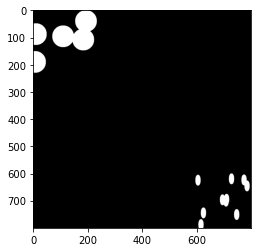

In [201]:
plt.imshow(realizations[0], cmap='gray')
plt.show()

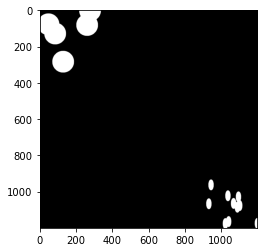

In [203]:
# Do the same for large grid size
grid_size = (1200, 1200)

n_circles = 5
circle_radii = [1/20*grid_size[0]] * n_circles  # 1/20 of the grid size
circle_distortions = [0] * n_circles  # No distortion for circles

n_ellipses = 10
ellipse_radii = [(1/40*grid_size[0], 1/80*grid_size[0])] * n_ellipses  # Half the radius for all ellipses
ellipse_distortions = [0] * n_ellipses  # No distortion for ellipses

realizations = []

for _ in range(50):  # Generate 10 realizations
    # Generate positions for the circles in the upper left corner
    circle_positions = [(np.random.randint(0, grid_size[0]//4), np.random.randint(0, grid_size[1]//4)) for _ in range(n_circles)]

    # Generate positions for the ellipses in the lower right corner
    ellipse_positions = [(np.random.randint(3*grid_size[0]//4, grid_size[0]), np.random.randint(3*grid_size[1]//4, grid_size[1])) for _ in range(n_ellipses)]
    
    objects = make_objects(grid_size, 0, [], [], [], 
                       n_circles, circle_radii, circle_distortions, circle_positions,
                       n_ellipses, ellipse_radii, ellipse_distortions, ellipse_positions,
                       overlap=True)  # Allow overlap
    
    realizations.append(objects)
np.save('circles_and_ellipses_huge.npy', realizations)
plt.imshow(realizations[0], cmap='gray')
plt.show()

In [176]:
mixed_shapes = np.zeros((50,400,400))
for i in range(50):
    mixed_shapes[i,:,:] = realizations[i]
np.save('mixed_shapes.npy', mixed_shapes)

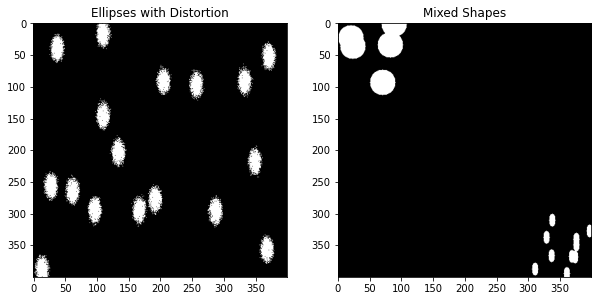

In [177]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ellipse_with_distortion[0], cmap='gray')
axs[0].set_title('Ellipses with Distortion')
axs[1].imshow(mixed_shapes[0], cmap='gray')
axs[1].set_title('Mixed Shapes')
plt.show()

In [122]:
import numpy as np

def generate_positions(grid_size, n_objects):
    return [(np.random.randint(0, grid_size), np.random.randint(0, grid_size)) for _ in range(n_objects)]

def create_object_mask(grid_size, position, size, distortion):
    x, y = np.ogrid[:grid_size, :grid_size]
    distorted_size = size + np.random.normal(0, distortion, (grid_size, grid_size))
    mask = (np.abs(x - position[0]) <= distorted_size/2) & (np.abs(y - position[1]) <= distorted_size/2)
    return mask

def make_square_objects(grid_size, n_objects, object_sizes, object_positions=None, overlap=False, distortion=0):
    if object_positions is None:
        object_positions = generate_positions(grid_size, n_objects)
    elif len(object_positions) < n_objects:
        raise ValueError("Not enough object positions provided")

    if isinstance(object_sizes, (list, tuple)) and len(object_sizes) < n_objects:
        raise ValueError("Not enough object sizes provided")

    objects = np.zeros((grid_size, grid_size))

    for i in range(n_objects):
        size = object_sizes[i] if isinstance(object_sizes, (list, tuple)) else object_sizes
        mask = create_object_mask(grid_size, object_positions[i], size, distortion)
        if overlap or not np.any(objects[mask]):
            objects[mask] = 1
        elif distortion != 0:
            new_position = generate_positions(grid_size, 1)[0]
            object_positions.append(new_position)
            mask = create_object_mask(grid_size, new_position, size, distortion)
            objects[mask] = 1

    return objects

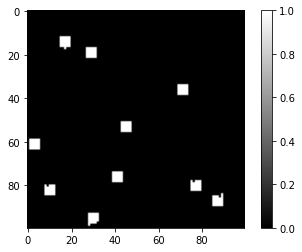

In [124]:
square_objects = make_square_objects(100, 10, 5, overlap=False, distortion=0.5)
plt.imshow(square_objects, cmap='gray')
plt.colorbar()
plt.show()

# 16 datasets

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

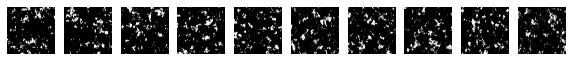

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

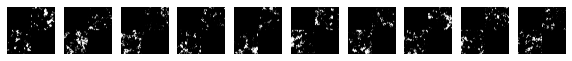

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

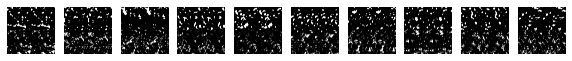

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

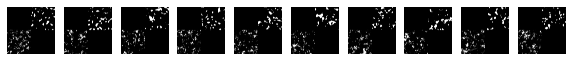

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

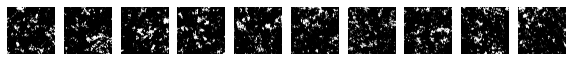

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

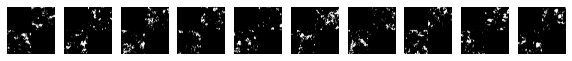

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

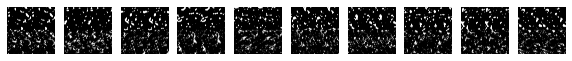

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

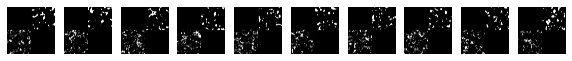

In [109]:
all_data = []
#[0,0,0,0] - low intensity (high proportion), low mean (low global smoothness), low var (stationary covariance), low clustering (no trends)
grid_size = 1000
n_samples = 100
global_var = 0.1
global_len_scale = 0.03
smoothness = 0.5
proportion = 0.9
seed = 2437
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[0][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,0,0,1] - low intensity, low mean, low var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[1][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,0,1,0] - low intensity, low mean, high var, low clustering
quadrant_params = [
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03}
        ]
seed = np.random.randint(10000)
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[2][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,0,1,1] - low intensity, low mean, high var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[3][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,0,0] - low intensity, high mean, low var, low clustering
smoothness = 0.5
quadrant_params = None
seed = np.random.randint(10000)
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[4][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,0,1] - low intensity, high mean, low var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[5][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,1,0] - low intensity, high mean, high var, low clustering
quadrant_params = [
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03}
        ]
seed = np.random.randint(10000)
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[6][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,1,1] - low intensity, high mean, high var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[7][i], cmap='gray')
    ax[i].axis('off')
plt.show()
np.save('TGRF_data_full_small_proportion.npy', all_data)

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

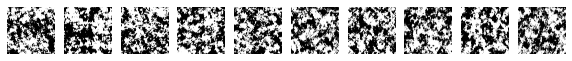

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

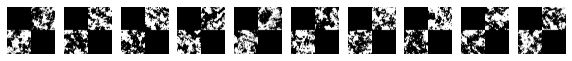

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

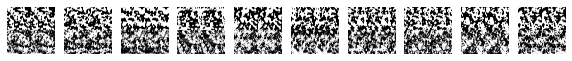

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

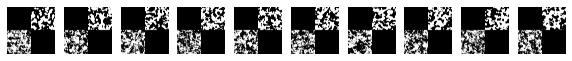

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

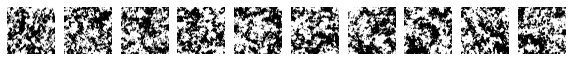

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

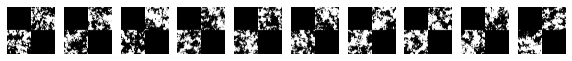

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

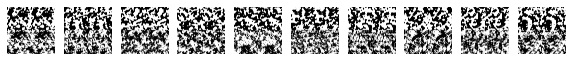

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

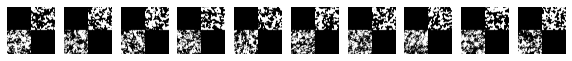

In [103]:
all_data = []
#[0,0,0,0] - low intensity (high proportion), low mean (low global smoothness), low var (stationary covariance), low clustering (no trends)
grid_size = 1000
n_samples = 100
global_var = 0.1
global_len_scale = 0.03
smoothness = 0.5
proportion = 0.5
seed = 2437
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[0][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,0,0,1] - low intensity, low mean, low var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[1][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,0,1,0] - low intensity, low mean, high var, low clustering
quadrant_params = [
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03}
        ]
seed = np.random.randint(10000)
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[2][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,0,1,1] - low intensity, low mean, high var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[3][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,0,0] - low intensity, high mean, low var, low clustering
smoothness = 0.5
quadrant_params = None
seed = np.random.randint(10000)
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[4][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,0,1] - low intensity, high mean, low var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[5][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,1,0] - low intensity, high mean, high var, low clustering
quadrant_params = [
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 4.0, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03},
            {'smoothness': 0.5, 'len_scale': 0.03}
        ]
seed = np.random.randint(10000)
all_data.append(make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params))
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[6][i], cmap='gray')
    ax[i].axis('off')
plt.show()
#[0,1,1,1] - low intensity, high mean, high var, high clustering
seed = np.random.randint(10000)
datum = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, proportion, seed, quadrant_params=quadrant_params)
for i in range(len(datum)):
    datum[i][0:500, 0:500] = 0
    datum[i][500:, 500:] = 0
all_data.append(datum)
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(all_data[7][i], cmap='gray')
    ax[i].axis('off')
plt.show()


# Save data
np.save('TGRF_data.npy', all_data)

In [104]:
heisann = np.load('TGRF_data.npy')

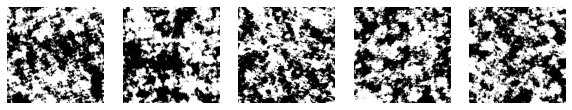

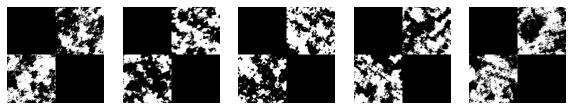

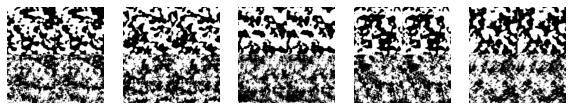

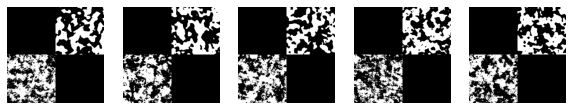

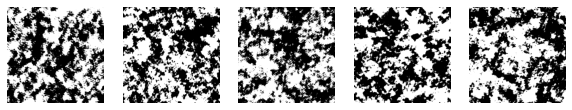

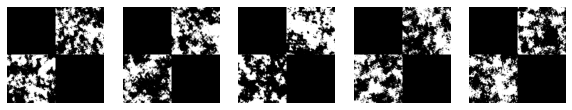

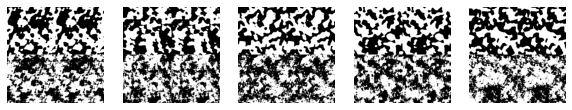

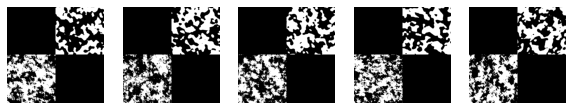

In [105]:
for i in range(len(heisann)):
    fig, ax = plt.subplots(1, 5, figsize=(10, 2))
    for j in range(5):
        ax[j].imshow(heisann[i][j], cmap='gray')
        ax[j].axis('off')
    plt.show()

In [106]:
from Reduced_functions import *

In [107]:
def oscar_vector(image):
    local_max_with_radii = find_local_maxima(image, allow_ties=True)
    vec = np.zeros(4)
    grid_size = image.shape[0]*image.shape[1]
    # First feature is the white pixel ratio
    vec[0] = np.sum(image)/grid_size
    # Second feature is the average fill rate of radius
    connectivity = generate_binary_structure(2, 2)
    labeled_array, num_features = label(image, structure=connectivity)
    fill_rates = np.zeros(len(local_max_with_radii))
    anchor_pic = np.zeros_like(image)
    for i in range(len(local_max_with_radii)):
        x, y, r = local_max_with_radii[i]
        component = (labeled_array == labeled_array[x, y])
        fill_rates[i] = r/np.sum(component)
        anchor_pic[x, y] = 1
    vec[1] = np.mean(fill_rates)
    vec[2] = np.var(fill_rates) * 4
    # Fourth feature is the custom metric
    vec[3] = construct_metric(anchor_pic)
    return vec

In [108]:
#all_anchors = []
all_vectors = []
for i in range(len(heisann)):
    #anchors = []
    vectors = []
    for j in range(len(heisann[i])):
        #anchors.append(find_local_maxima(all_data[i][j]))
        vectors.append(oscar_vector(heisann[i][j]))
    #all_anchors.append(anchors)
    all_vectors.append(vectors)

KeyboardInterrupt: 

In [ ]:
#np.save('TGRF_anchors.npy', np.array(all_anchors))
np.save('TGRF_vectors_oscar.npy', np.array(all_vectors))

In [ ]:
from re import sub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plotting_vecs(all_vecs,labels,datanames,some_colors,subplot_dim):
    extrema_vals = np.zeros((4,2))
    for i in range(4):
        extrema_vals[i,0] = np.max([np.max(np.array(all_vecs[j])[:,0]) for j in range(len(all_vecs))])
        extrema_vals[i,1] = np.min([np.min(np.array(all_vecs[j])[:,0]) for j in range(len(all_vecs))])
    normalized_vecs = []
    for i in range(len(all_vecs)):
        vecs = []
        for j in range(len(all_vecs[i])):
            curr_vec = all_vecs[i][j]
            vecs.append(np.array([(curr_vec[0]-extrema_vals[0,0])/(extrema_vals[0,1]-extrema_vals[0,0]), 
                                  (curr_vec[1]-extrema_vals[1,0])/(extrema_vals[1,1]-extrema_vals[1,0]), 
                                  (curr_vec[2]-extrema_vals[2,0])/(extrema_vals[2,1]-extrema_vals[2,0]), 
                                  (curr_vec[3]-extrema_vals[3,0])/(extrema_vals[3,1]-extrema_vals[3,0])]))
        normalized_vecs.append(vecs)

    fig, axes = plt.subplots(subplot_dim[0], subplot_dim[1], figsize=(15, 15))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    # Plot the data in matrix form
    for i in range(subplot_dim[0]):
        for j in range(subplot_dim[1]):
            if i == j:
                for k in range(len(all_vecs)):
                    axes[i, j].hist(np.array(all_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    #axes[i, j].legend()
            else:
                for k in range(len(all_vecs)):
                    axes[i, j].scatter(np.array(all_vecs[k])[:,j], np.array(all_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    #axes[i, j].legend()
            if i == 3:
                axes[i, j].set_xlabel(labels[j])
            if j == 0:
                axes[i, j].set_ylabel(labels[i])

    # Create a new figure for the legend
    fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

    # Create legend handles manually
    handles = [mpatches.Patch(color=some_colors[i], label=datanames[i]) for i in range(len(datanames))]

    # Add the legend to the subplot
    ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

    # Hide the axes
    ax_legend.axis('off')

    # Show the plots
    plt.show()

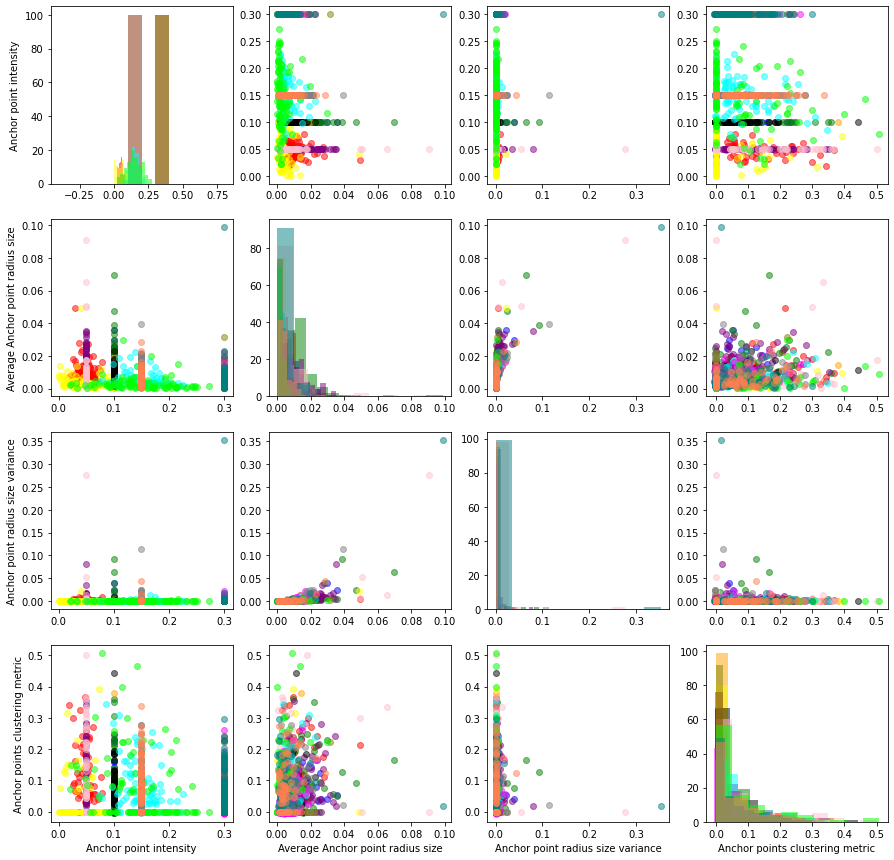

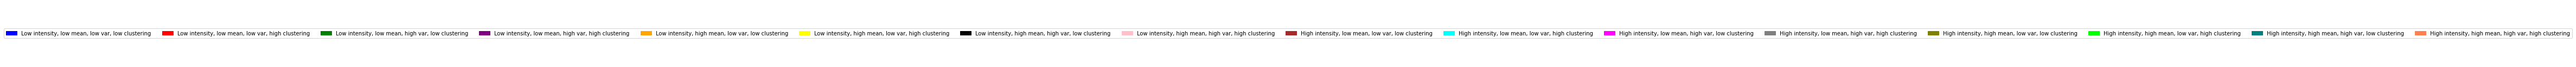

In [ ]:
labels = ['Anchor point intensity', 'Average Anchor point radius size', 'Anchor point radius size variance', 'Anchor points clustering metric']
datanames = ['Low intensity, low mean, low var, low clustering', 'Low intensity, low mean, low var, high clustering', 
             'Low intensity, low mean, high var, low clustering', 'Low intensity, low mean, high var, high clustering',
             'Low intensity, high mean, low var, low clustering', 'Low intensity, high mean, low var, high clustering',
             'Low intensity, high mean, high var, low clustering', 'Low intensity, high mean, high var, high clustering',
             'High intensity, low mean, low var, low clustering', 'High intensity, low mean, low var, high clustering',
             'High intensity, low mean, high var, low clustering', 'High intensity, low mean, high var, high clustering',
             'High intensity, high mean, low var, low clustering', 'High intensity, high mean, low var, high clustering',
             'High intensity, high mean, high var, low clustering', 'High intensity, high mean, high var, high clustering']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink', 'brown', 'cyan', 'magenta', 'grey', 'olive', 'lime', 'teal', 'coral']
subplot_dim = (4,4)
#indexes = [5,7,11]
plotting_vecs(all_vectors,labels,datanames,some_colors,subplot_dim)

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

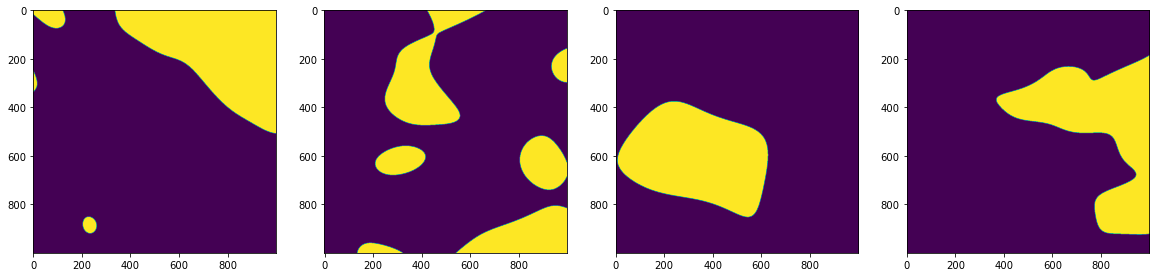

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

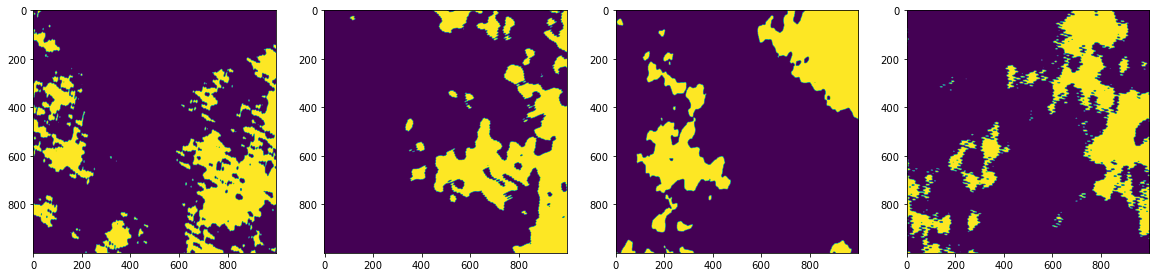

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

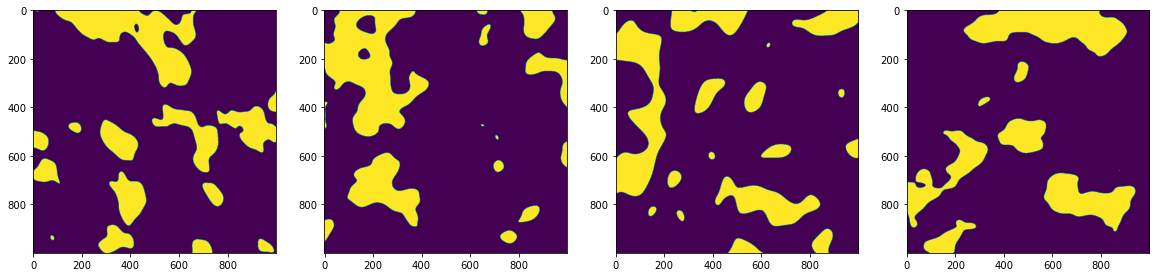

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

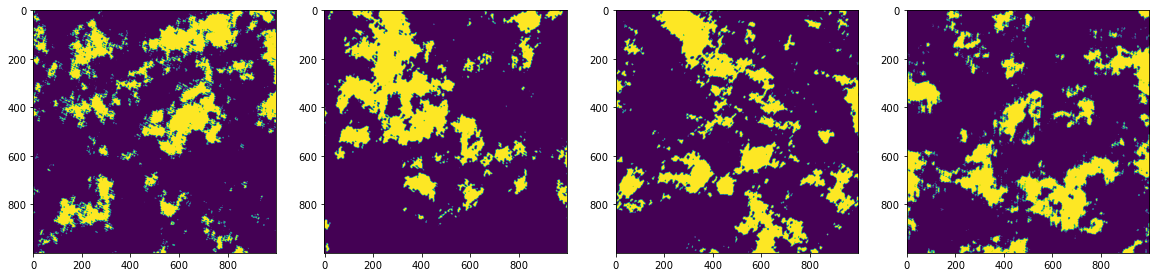

Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configuration.
Sample number: 19/100 for current configuration.
Sample number: 20/100 for current configuration.
Sample number: 21/100 for cur

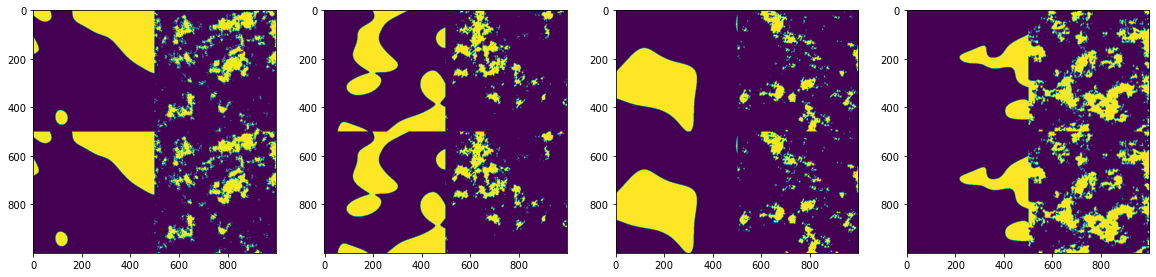

In [25]:
quadrant_params = [
            {'smoothness': 3.0, 'len_scale': 0.2},
            {'smoothness': 0.5, 'len_scale': 0.05},
            {'smoothness': 3.0, 'len_scale': 0.2},
            {'smoothness': 0.5, 'len_scale': 0.05}
        ]
grid_size = 1000
n_samples = 100
global_var = 1.0
global_len_scale = 0.2
smoothness = 3.0
tgrf_long_length_high_smoothness = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=2437)
ax, fig = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
    fig[i].imshow(tgrf_long_length_high_smoothness[i])
plt.show()
smoothness = 0.5
tgrf_long_length_low_smoothness = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=2437)
ax, fig = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
    fig[i].imshow(tgrf_long_length_low_smoothness[i])
plt.show()
global_len_scale = 0.05
smoothness = 3.0
tgrf_short_length_high_smoothness = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=2437)
ax, fig = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
    fig[i].imshow(tgrf_short_length_high_smoothness[i])
plt.show()
smoothness = 0.5
tgrf_short_length_low_smoothness = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=2437)
ax, fig = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
    fig[i].imshow(tgrf_short_length_low_smoothness[i])
plt.show()
tgrf_quadrants = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=2437, quadrant_params=quadrant_params)
ax, fig = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
    fig[i].imshow(tgrf_quadrants[i])
plt.show()

#seed = 2437
#samps = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=seed,quadrant_params=quadrant_params)



In [27]:
# Save the samples
np.save('tgrf_long_length_high_smoothness.npy', tgrf_long_length_high_smoothness)
np.save('tgrf_long_length_low_smoothness.npy', tgrf_long_length_low_smoothness)
np.save('tgrf_short_length_high_smoothness.npy', tgrf_short_length_high_smoothness)
np.save('tgrf_short_length_low_smoothness.npy', tgrf_short_length_low_smoothness)
np.save('tgrf_quadrants.npy', tgrf_quadrants)

In [29]:
from Reduced_functions import *

In [42]:
# Save the vectors
np.save('all_vectors_TGRF.npy',all_vectors)

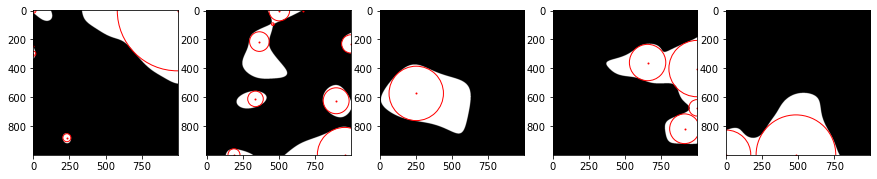

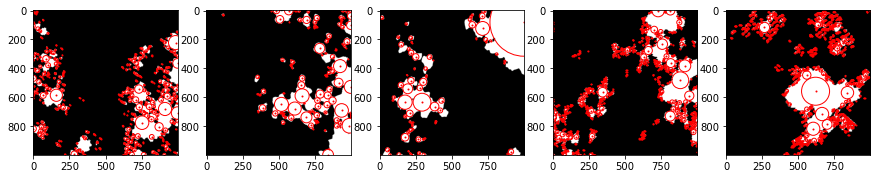

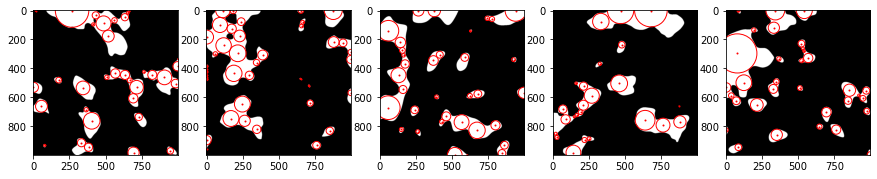

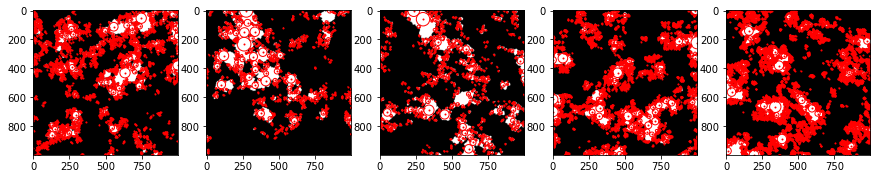

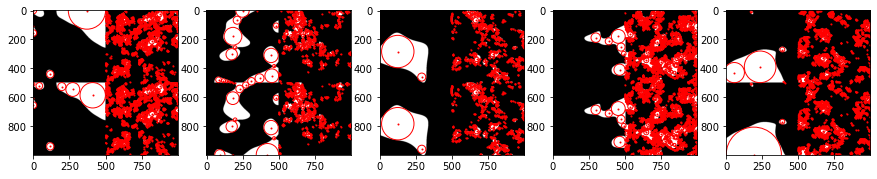

In [30]:
all_anchors = []
all_vectors = []
for data in all_data:
    anchors = []
    vectors = []
    for i in range(len(data)):
        anchors.append(find_local_maxima(data[i], allow_ties=True))
        vectors.append(oscar_ragnar_vec(data[i]))
    all_anchors.append(anchors)
    all_vectors.append(vectors)

for j in range(len(all_data)):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        ax[i].imshow(all_data[j][i], cmap='gray')
        for x, y, r in all_anchors[j][i]:
            ax[i].plot(y, x, 'ro', markersize=1)
            ax[i].add_artist(plt.Circle((y, x), r, color='r', fill=False))
    plt.show()

In [38]:
from re import sub
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plotting_vecs(all_vecs,labels,datanames,some_colors,subplot_dim):
    extrema_vals = np.zeros((4,2))
    for i in range(4):
        extrema_vals[i,0] = np.max([np.max(np.array(all_vecs[j])[:,0]) for j in range(len(all_vecs))])
        extrema_vals[i,1] = np.min([np.min(np.array(all_vecs[j])[:,0]) for j in range(len(all_vecs))])
    normalized_vecs = []
    for i in range(len(all_vecs)):
        vecs = []
        for j in range(len(all_vecs[i])):
            curr_vec = all_vecs[i][j]
            vecs.append(np.array([(curr_vec[0]-extrema_vals[0,0])/(extrema_vals[0,1]-extrema_vals[0,0]), 
                                  (curr_vec[1]-extrema_vals[1,0])/(extrema_vals[1,1]-extrema_vals[1,0]), 
                                  (curr_vec[2]-extrema_vals[2,0])/(extrema_vals[2,1]-extrema_vals[2,0]), 
                                  (curr_vec[3]-extrema_vals[3,0])/(extrema_vals[3,1]-extrema_vals[3,0])]))
        normalized_vecs.append(vecs)

    fig, axes = plt.subplots(subplot_dim[0], subplot_dim[1], figsize=(15, 15))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    # Plot the data in matrix form
    for i in range(subplot_dim[0]):
        for j in range(subplot_dim[1]):
            if i == j:
                for k in range(len(all_vecs)):
                    axes[i, j].hist(np.array(all_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    #axes[i, j].legend()
            else:
                for k in range(len(all_vecs)):
                    axes[i, j].scatter(np.array(all_vecs[k])[:,j], np.array(all_vecs[k])[:,i],label=datanames[k],color=some_colors[k],alpha=0.5)
                    #axes[i, j].legend()
            if i == 3:
                axes[i, j].set_xlabel(labels[j])
            if j == 0:
                axes[i, j].set_ylabel(labels[i])

    # Create a new figure for the legend
    fig_legend, ax_legend = plt.subplots(figsize=(10, 2))  # Adjust the figure size to accommodate the horizontal legend

    # Create legend handles manually
    handles = [mpatches.Patch(color=some_colors[i], label=datanames[i]) for i in range(len(datanames))]

    # Add the legend to the subplot
    ax_legend.legend(handles=handles, loc='center', ncol=len(handles))

    # Hide the axes
    ax_legend.axis('off')

    # Show the plots
    plt.show()

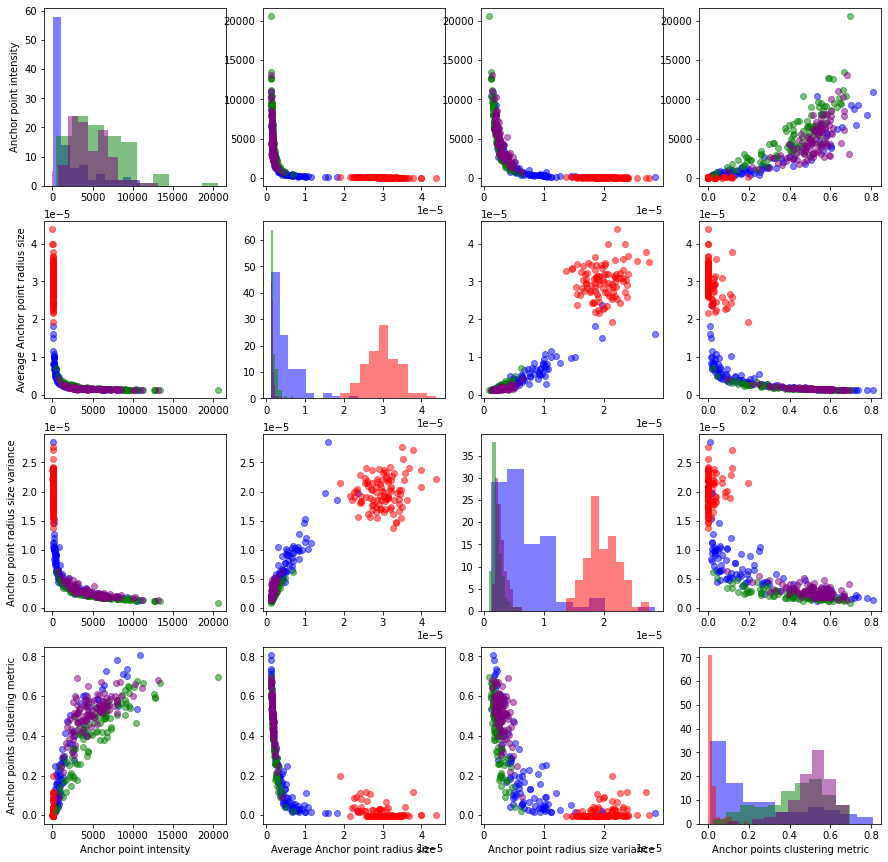

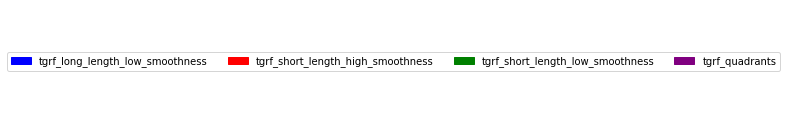

In [41]:
all_vectors_2 = all_vectors[1:]
labels = ['Anchor point intensity', 'Average Anchor point radius size', 'Anchor point radius size variance', 'Anchor points clustering metric']
datanames = ['tgrf_long_length_low_smoothness', 'tgrf_short_length_high_smoothness', 'tgrf_short_length_low_smoothness', 'tgrf_quadrants']
some_colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black', 'pink']
subplot_dim = (4,4)
plotting_vecs(all_vectors_2,labels,datanames,some_colors,subplot_dim)

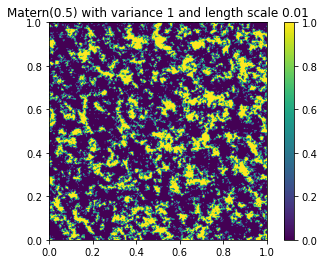

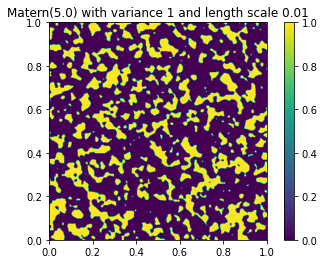

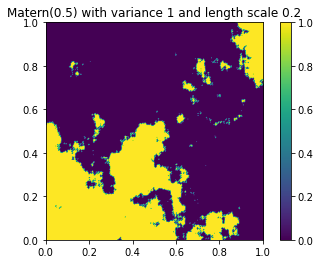

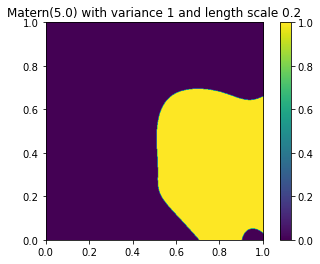

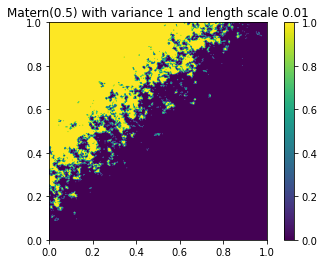

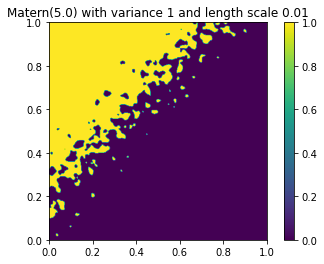

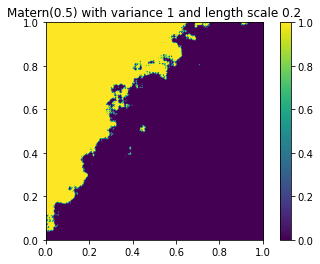

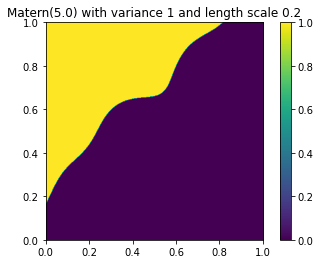

In [12]:
quadrant_params = [
            {'smoothness': 3.0, 'len_scale': 0.2},
            {'smoothness': 0.5, 'len_scale': 0.05},
            {'var': 3.0, 'len_scale': 0.05},
            {'var': 0.5, 'len_scale': 0.2}
        ]
len_scales = [0.01, 0.2]
smoothnesses = [0.5, 5.0]
grid_size = 500
def trend(x,y):
    z = np.zeros((len(x), len(y)))
    for i in range(len(x)):
        for j in range(len(y)):
            z[i, j] = 10 * x[i] - 10 * y[j]
    return z
def zero_trend(x,y):
    return 0
trends = [zero_trend,trend]
for tre in trends:
    for len_scale in len_scales:
      for smoothness in smoothnesses:
            base_cov_model = gs.Matern(dim=2, var=1, len_scale=len_scale, nu=smoothness)
            srf = gs.SRF(base_cov_model)

            # Create the spatial grid
            x = np.linspace(0, 1, grid_size)
            y = np.linspace(0, 1, grid_size)

            # Evaluate the SRF
            srf_values = srf((x, y), mesh_type='structured', seed=1234) + tre(x, y)
            sample = np.zeros_like(srf_values)
            threshold = np.percentile(srf_values, 70)
            sample[srf_values > threshold] = 1
            # Plot the SRF
            plt.figure()
            plt.imshow(sample, origin='lower', extent=(0, 1, 0, 1))
            plt.colorbar()
            plt.title(f"Matern({smoothness}) with variance {1} and length scale {len_scale}")
            plt.show()


Sample number: 0 out of 1


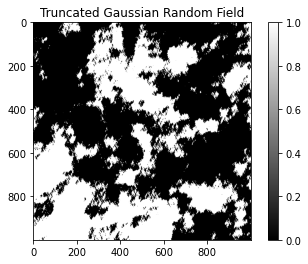

In [4]:
def make_TGRF(n_samples, var, len_scale, smoothness, grid_size, seed=2435, 
              anisotropy_zones=None, stationarity_zones=None):
    # Base covariance model (will be adjusted locally)
    base_cov_model = gs.Matern(dim=2, var=var, len_scale=len_scale, nu=smoothness)
    srf = gs.SRF(base_cov_model)
    
    # Create the spatial grid
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    
    samples = np.zeros((n_samples, grid_size, grid_size))
    
    for i in range(n_samples):
        seed = seed + i
        if anisotropy_zones or stationarity_zones:
            # Create a field for local variations
            local_field = np.zeros((grid_size, grid_size))
            for xi in range(grid_size):
                for yi in range(grid_size):
                    # Apply anisotropy zones
                    if anisotropy_zones:
                        for (cx, cy, zone_len_scale, zone_var) in anisotropy_zones:
                            if (xi - cx)**2 + (yi - cy)**2 < (zone_len_scale * grid_size)**2:
                                local_cov_model = gs.Matern(
                                    dim=2, var=zone_var, len_scale=zone_len_scale, nu=smoothness)
                                local_srf = gs.SRF(local_cov_model)
                                local_field[xi, yi] = local_srf((x[xi], y[yi]), mesh_type='structured', seed=seed)
                    # Apply stationarity zones
                    if stationarity_zones:
                        for (cx, cy, radius, mean_value) in stationarity_zones:
                            if (xi - cx)**2 + (yi - cy)**2 < radius**2:
                                srf.mean[xi, yi] = mean_value
            
            GRF = local_field
        else:
            GRF = srf.structured((x, y), seed=seed)
        
        # Truncate to binary array based on the 60th percentile
        sample = np.zeros_like(GRF)
        threshold = np.percentile(GRF, 60)
        sample[GRF > threshold] = 1
        samples[i] = sample
        print("Sample number:", i, "out of", n_samples)
    
    return samples

# Parameters
n_samples = 1
var = 0.01
len_scale = 0.1
smoothness = 0.5
grid_size = 1000
seed = np.random.randint(0, 1000)
# Anisotropy zones: (center_x, center_y, local_len_scale, local_var)
anisotropy_zones = [
    (200, 200, 0.05, 1.5),
    (800, 200, 0.2, 0.5),
    (500, 800, 0.1, 2.0)
]

# Stationarity zones: (center_x, center_y, radius, mean_value)
stationarity_zones = [
    (500, 500, 100, 1),
    (300, 300, 50, -1)
]

# Generate samples
samples = make_TGRF(n_samples, var, len_scale, smoothness, grid_size,seed = seed)

# Plot the first sample
plt.imshow(samples[0], cmap='gray')
plt.title('Truncated Gaussian Random Field')
plt.colorbar()
plt.show()

Sample number: 0 out of 1


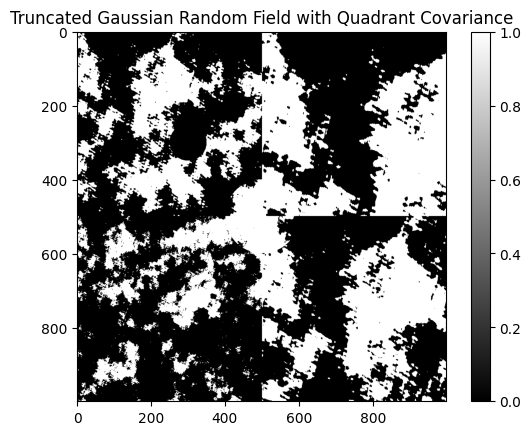

In [5]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt

def make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=2437, 
              quadrant_params=None, stationarity_zones=None):
    samples = np.zeros((n_samples, grid_size, grid_size))
    
    for i in range(n_samples):
        seed = seed + i
        local_field = np.zeros((grid_size, grid_size))
        
        if quadrant_params:
            mid_x, mid_y = grid_size // 2, grid_size // 2
            
            for qx in range(2):
                for qy in range(2):
                    lx_start = qx * mid_x
                    lx_end = (qx + 1) * mid_x
                    ly_start = qy * mid_y
                    ly_end = (qy + 1) * mid_y
                    
                    q_var = quadrant_params[qx * 2 + qy]['var']
                    q_len_scale = quadrant_params[qx * 2 + qy]['len_scale']
                    
                    cov_model = gs.Matern(dim=2, var=q_var, len_scale=q_len_scale, nu=smoothness)
                    srf = gs.SRF(cov_model)
                    
                    x = np.linspace(0, 1, mid_x)
                    y = np.linspace(0, 1, mid_y)
                    
                    GRF = srf.structured((x, y), seed=seed)
                    local_field[lx_start:lx_end, ly_start:ly_end] = GRF
        
        if stationarity_zones:
            for (cx, cy, radius, mean_value) in stationarity_zones:
                for xi in range(grid_size):
                    for yi in range(grid_size):
                        if (xi - cx)**2 + (yi - cy)**2 < radius**2:
                            local_field[xi, yi] += mean_value
        
        # Truncate to binary array at 60th percentile
        threshold = np.percentile(local_field, 60)
        sample = np.zeros_like(local_field)
        sample[local_field > threshold] = 1
        samples[i] = sample
        print("Sample number:", i, "out of", n_samples)
    
    return samples

# Parameters
n_samples = 1
global_var = 1.0
global_len_scale = 0.1
smoothness = 0.5
grid_size = 1000

# Quadrant parameters: (variance, length_scale)
quadrant_params = [
    {'var': 1.0, 'len_scale': 0.1},
    {'var': 2.0, 'len_scale': 0.2},
    {'var': 0.5, 'len_scale': 0.05},
    {'var': 1.5, 'len_scale': 0.15}
]

# Stationarity zones: (center_x, center_y, radius, mean_value)
stationarity_zones = [
    (500, 500, 100, 1),
    (300, 300, 50, -1)
]

# Generate samples
samples = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, 
                    quadrant_params=quadrant_params, stationarity_zones=stationarity_zones)

# Plot the first sample
plt.imshow(samples[0], cmap='gray')
plt.title('Truncated Gaussian Random Field with Quadrant Covariance')
plt.colorbar()
plt.show()


Processing dataset 1/16 with parameters: {'stationary': True, 'locally_varying': False, 'variance': 'high', 'length_scale': 'long'}
Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.
Sample number: 6/100 for current configuration.
Sample number: 7/100 for current configuration.
Sample number: 8/100 for current configuration.
Sample number: 9/100 for current configuration.
Sample number: 10/100 for current configuration.
Sample number: 11/100 for current configuration.
Sample number: 12/100 for current configuration.
Sample number: 13/100 for current configuration.
Sample number: 14/100 for current configuration.
Sample number: 15/100 for current configuration.
Sample number: 16/100 for current configuration.
Sample number: 17/100 for current configuration.
Sample number: 18/100 for current configurat

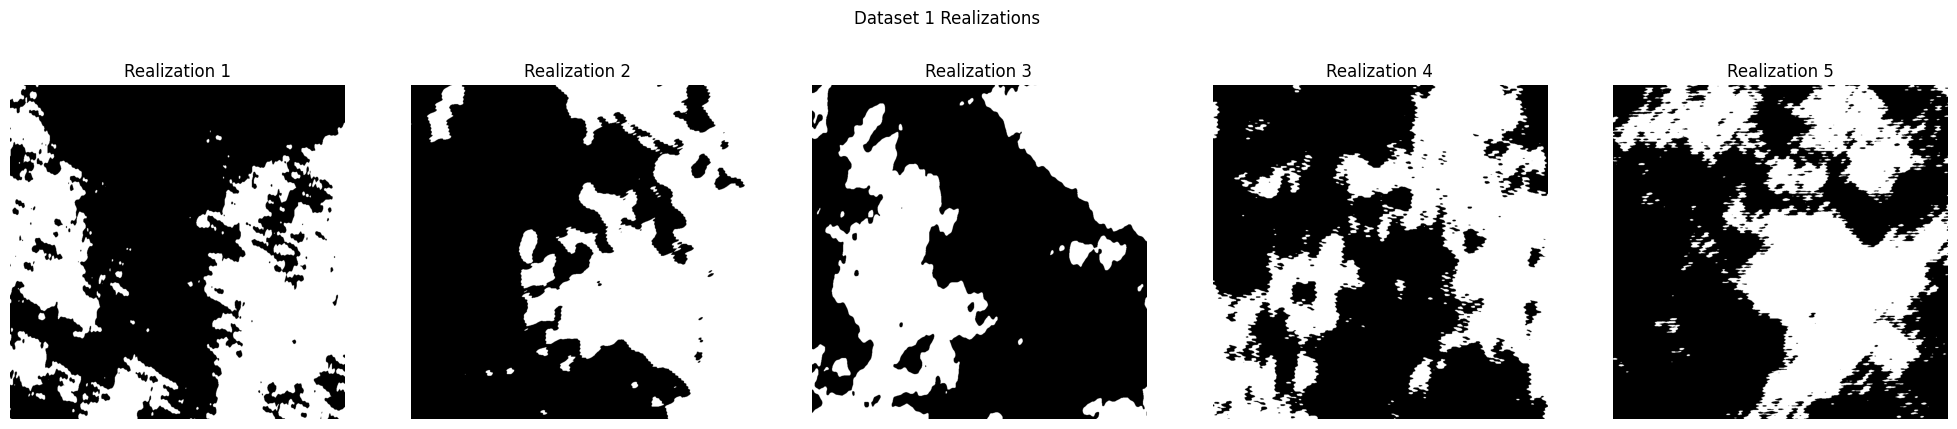

Processing dataset 2/16 with parameters: {'stationary': True, 'locally_varying': False, 'variance': 'high', 'length_scale': 'short'}
Sample number: 1/100 for current configuration.
Sample number: 2/100 for current configuration.
Sample number: 3/100 for current configuration.
Sample number: 4/100 for current configuration.
Sample number: 5/100 for current configuration.


In [7]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
import os

def make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, seed=2437, 
              quadrant_params=None, stationarity_zones=None):
    samples = np.zeros((n_samples, grid_size, grid_size))
    
    for i in range(n_samples):
        seed = seed + i
        local_field = np.zeros((grid_size, grid_size))
        
        if quadrant_params:
            mid_x, mid_y = grid_size // 2, grid_size // 2
            
            for qx in range(2):
                for qy in range(2):
                    lx_start = qx * mid_x
                    lx_end = (qx + 1) * mid_x
                    ly_start = qy * mid_y
                    ly_end = (qy + 1) * mid_y
                    
                    q_var = quadrant_params[qx * 2 + qy]['var']
                    q_len_scale = quadrant_params[qx * 2 + qy]['len_scale']
                    
                    cov_model = gs.Matern(dim=2, var=q_var, len_scale=q_len_scale, nu=smoothness)
                    srf = gs.SRF(cov_model)
                    
                    x = np.linspace(0, 1, mid_x)
                    y = np.linspace(0, 1, mid_y)
                    
                    GRF = srf.structured((x, y), seed=seed)
                    local_field[lx_start:lx_end, ly_start:ly_end] = GRF
        else:
            cov_model = gs.Matern(dim=2, var=global_var, len_scale=global_len_scale, nu=smoothness)
            srf = gs.SRF(cov_model)
            x = np.linspace(0, 1, grid_size)
            y = np.linspace(0, 1, grid_size)
            local_field = srf.structured((x, y), seed=seed)
        
        if stationarity_zones:
            for (cx, cy, radius, mean_value) in stationarity_zones:
                for xi in range(grid_size):
                    for yi in range(grid_size):
                        if (xi - cx)**2 + (yi - cy)**2 < radius**2:
                            local_field[xi, yi] += mean_value
        
        # Truncate to binary array at 60th percentile
        threshold = np.percentile(local_field, 60)
        sample = np.zeros_like(local_field)
        sample[local_field > threshold] = 1
        samples[i] = sample
        print(f"Sample number: {i+1}/{n_samples} for current configuration.")
    
    return samples

# Parameters
n_samples = 100
smoothness = 0.5
grid_size = 1000

# Create directory for datasets
output_dir = "datasets"
os.makedirs(output_dir, exist_ok=True)

# Define parameter combinations
param_combinations = [
    {"stationary": True, "locally_varying": False, "variance": "high", "length_scale": "long"},
    {"stationary": True, "locally_varying": False, "variance": "high", "length_scale": "short"},
    {"stationary": True, "locally_varying": False, "variance": "low", "length_scale": "long"},
    {"stationary": True, "locally_varying": False, "variance": "low", "length_scale": "short"},
    {"stationary": True, "locally_varying": True, "variance": "high", "length_scale": "long"},
    {"stationary": True, "locally_varying": True, "variance": "high", "length_scale": "short"},
    {"stationary": True, "locally_varying": True, "variance": "low", "length_scale": "long"},
    {"stationary": True, "locally_varying": True, "variance": "low", "length_scale": "short"},
    {"stationary": False, "locally_varying": False, "variance": "high", "length_scale": "long"},
    {"stationary": False, "locally_varying": False, "variance": "high", "length_scale": "short"},
    {"stationary": False, "locally_varying": False, "variance": "low", "length_scale": "long"},
    {"stationary": False, "locally_varying": False, "variance": "low", "length_scale": "short"},
    {"stationary": False, "locally_varying": True, "variance": "high", "length_scale": "long"},
    {"stationary": False, "locally_varying": True, "variance": "high", "length_scale": "short"},
    {"stationary": False, "locally_varying": True, "variance": "low", "length_scale": "long"},
    {"stationary": False, "locally_varying": True, "variance": "low", "length_scale": "short"},
]

# Process each parameter combination
for idx, params in enumerate(param_combinations):
    print(f"Processing dataset {idx+1}/{len(param_combinations)} with parameters: {params}")
    
    global_var = 2.0 if params["variance"] == "high" else 0.5
    global_len_scale = 0.2 if params["length_scale"] == "long" else 0.05
    
    stationarity_zones = None
    if not params["stationary"]:
        stationarity_zones = [
            (500, 500, 100, 1),
            (300, 300, 50, -1)
        ]
    
    quadrant_params = None
    if params["locally_varying"]:
        quadrant_params = [
            {'var': 2.0, 'len_scale': 0.2},
            {'var': 0.5, 'len_scale': 0.05},
            {'var': 1.0, 'len_scale': 0.1},
            {'var': 0.5, 'len_scale': 0.2}
        ]
    
    # Generate the dataset
    samples = make_TGRF(n_samples, global_var, global_len_scale, smoothness, grid_size, 
                        quadrant_params=quadrant_params, stationarity_zones=stationarity_zones)
    
    # Save the dataset
    dataset_name = f"dataset_{idx+1}_stationary_{params['stationary']}_locally_varying_{params['locally_varying']}_variance_{params['variance']}_length_scale_{params['length_scale']}.npy"
    np.save(os.path.join(output_dir, dataset_name), samples)
    print(f"Saved {dataset_name}\n")
    
    # Plot the first five realizations
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    for i in range(5):
        axes[i].imshow(samples[i], cmap='gray')
        axes[i].set_title(f"Realization {i+1}")
        axes[i].axis('off')
    plt.suptitle(f"Dataset {idx+1} Realizations")
    plt.show()

print("All datasets have been generated and saved.")



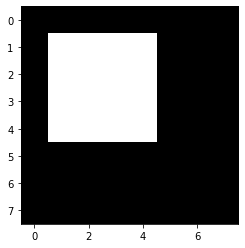

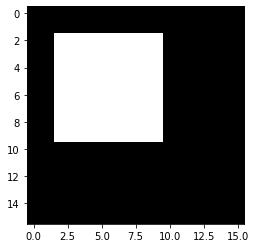

In [26]:
from scipy.ndimage import distance_transform_edt, label, generate_binary_structure, find_objects
array_8 = np.zeros((8,8))
array_16 = np.zeros((16,16))
array_8[1:5,1:5] = 1
array_16[2:10,2:10] = 1
plt.imshow(array_8, cmap='gray')
plt.show()
plt.imshow(array_16, cmap='gray')
plt.show()
array_8_dt = distance_transform_edt(array_8)
array_16_dt = distance_transform_edt(array_16)

In [29]:
hei = np.array(([0,1,1,1,1],
              [0,0,1,1,1],
              [0,1,1,1,1],
              [0,1,1,1,0],
              [0,1,1,0,0]))
print(distance_transform_edt(hei))

[[0.         1.         1.41421356 2.23606798 3.        ]
 [0.         0.         1.         2.         2.        ]
 [0.         1.         1.41421356 1.41421356 1.        ]
 [0.         1.         1.41421356 1.         0.        ]
 [0.         1.         1.         0.         0.        ]]


In [27]:
array_8_dt

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 2., 2., 1., 0., 0., 0.],
       [0., 1., 2., 2., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [28]:
array_16_dt

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 2., 2., 2., 2., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 3., 3., 3., 3., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 3., 4., 4., 3., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 3., 4., 4., 3., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 3., 3., 3., 3., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 2., 2., 2., 2., 2., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
# Make a function that converts grid cells to a grid-free position
def gridposition_to_coordinate(grid_position, grid_size, image_size = 1000):
    # Compute the size of the grid cells
    grid_cell_size = image_size / grid_size

    # Compute the x and y coordinates of the grid cell
    x = grid_position[0] * grid_cell_size 
    y = grid_position[1] * grid_cell_size 

    return x, y

def custom_distance_transform(array, image_size = 1000):
    foreground_positions = np.argwhere(array).flatten()
    background_positions = np.argwhere(array == 0).flatten()
    mindist_pos = np.zeros_like(array)
    mindist_coord = np.zeros_like(array)
    for foreground in foreground_positions:
        curr_min_pos = np.inf
        curr_min_coord = np.inf 
        for background in background_positions:
            dist_grid = np.linalg.norm(np.array(np.unravel_index(foreground, array.shape)) - np.array(np.unravel_index(background, array.shape)))
            foreground_coord = gridposition_to_coordinate(np.unravel_index(foreground, array.shape), array.shape[0], image_size)
            background_coord = gridposition_to_coordinate(np.unravel_index(background, array.shape), array.shape[0], image_size)
            dist_real = np.linalg.norm(foreground_coord - background_coord)
            if dist_real < curr_min_coord:
                curr_min_coord = dist_real
            if dist_grid < curr_min_pos:
                curr_min_pos = dist_grid
        mindist_pos[np.unravel_index(foreground, array.shape)] = curr_min_pos
        mindist_coord[np.unravel_index(foreground, array.shape)] = curr_min_coord
    return mindist_pos, mindist_coord


In [36]:
np.linalg.norm(np.argwhere(array_8)[0]-np.argwhere(array_8)[6])

2.23606797749979

In [37]:
np.argwhere(array_8)[6]

array([2, 3])